In [3]:
import torch as t
import pandas as pd
import numpy as np
from tqdm import tqdm

from torch.nn import GRU
from src.preprocess import *
from src.models import *
from src.utils import *

from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.simplefilter('ignore')


In [4]:
# setting up
DEVICE = 'cuda' if t.cuda.is_available() else 'cpu'
DEVICE = 'mps' if t.backends.mps.is_available() else DEVICE
DATASET_PATH = './dataset/result.csv'
LOOK_FWD = 700
W_SIZE = 50
THR = 0.000001
TRAIN_TEST_R = 0.8
TRAIN_VAL_R = 0.8
HIDDEN = 60
N_LAYERS = 5
BATCH_SIZE = 1024

In [5]:
unzip_dataset('./dataset/')
dataset = pd.read_csv(DATASET_PATH, index_col=0)[:100000]
dataset.shape

Dataset already extracted


(100000, 79)

In [6]:
labels = generate_labels(dataset, LOOK_FWD, THR)[LOOK_FWD:]

100%|██████████| 99300/99300 [00:04<00:00, 23519.77it/s]


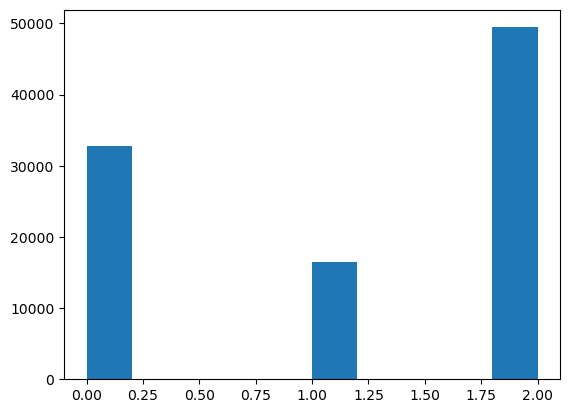

In [7]:
import matplotlib.pyplot as plt
plt.hist(labels)
plt.show()

In [8]:
labels.shape

(98600,)

In [9]:
pipe = Pipe(W_SIZE)

train_index = int((dataset.shape[0] - LOOK_FWD * 2 - W_SIZE) * TRAIN_TEST_R)
test_index_start = train_index + W_SIZE
ds_train = dataset[:train_index]
ds_test = dataset[test_index_start: - LOOK_FWD * 2]

dataset = None

pipe.fit(ds_train)

train_t = pipe.transform(ds_train)
test_t = pipe.transform(ds_test)

train_l_t = t.tensor(labels[:train_t.shape[0]])
test_l_t = t.tensor(labels[test_index_start:test_index_start + test_t.shape[0]])

train_val_idx = int(train_l_t.shape[0] * TRAIN_VAL_R)

train_ds = t.utils.data.TensorDataset(train_t[:train_val_idx], train_l_t[:train_val_idx])
val_ds = t.utils.data.TensorDataset(train_t[train_val_idx:], train_l_t[train_val_idx:])
test_ds = t.utils.data.TensorDataset(test_t, test_l_t)

train_dl = t.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dl = t.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE)
test_dl = t.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE)

In [23]:
model = Att_GRU(train_t.shape[2], 5, 20, W_SIZE, DEVICE).to(device=DEVICE)
model(train_t[500:505].to(device=DEVICE)).shape

torch.Size([5, 3])

In [25]:
import torchmetrics as tm

class GetMetrics:
    def __init__(self, params = {
        'task' : 'multiclass', 
        'num_classes' : 3, 
        'average' : 'weighted'
    }):
        self.estimators = {
            'accuracy' : tm.Accuracy(**params),
            'precision' : tm.Precision(**params),
            'recall' : tm.Recall(**params)
        }
    
    def __call__(self, preds, labels, metrics = ['accuracy', 'precision', 'recall']):
        out = {}
        for n in metrics:
            if n in self.estimators.keys():
                out[n] = self.estimators[n] ( preds, labels)
            else: print("No {} metric found".format(n))
            
        return out


def train(train_loader, val_loader, model, optimizer, lf, epochs=10, device='cpu', sm=None):
    metrics = GetMetrics()

    
    bar = tqdm(range(epochs))
    epoch_loss = -1.0
    eval_loss = {
        'loss' : -1.0,
        'accuracy' : -1.0,
        'precision' : -1.0,
        'recall' : -1.0,
    }
    accuracy = -1.0
    precision = -1.0
    recall = -1.0
    for epoch in bar:
        l = 0
        acc = 0
        pre = 0
        rec = 0
        batch_count = 0
        for X, y in train_loader:
            batch_count += 1
            
            optimizer.zero_grad()
            X = X.to(device=device)
            out = model(X).to(device='cpu')
            loss = lf(out, y)
            loss.backward()
            optimizer.step()
            
            l += loss
            m = metrics(out, y)
            acc += m['accuracy']
            pre += m['precision']
            rec += m['recall']

            bar.set_description("train_loss: {:.3f}, train_acc_pre_rec: {:.3f}, {:.3f}, {:.3f}; || eval_loss: {:.3f}, eval_acc_pre_rec {:.3f}, {:.3f}, {:.3f}; || local_loss: {:.3f}"\
                                .format(epoch_loss, accuracy, precision, recall,\
                                        eval_loss['loss'], eval_loss['accuracy'], eval_loss['precision'], eval_loss['recall'],\
                                        loss))

        epoch_loss = l / batch_count
        accuracy = acc / batch_count
        precision = pre / batch_count
        recall = rec / batch_count
        eval_loss = eval(val_loader, model, lf, device)

        if sm is not None:
            sm.add_scalar('Accuracy/train', accuracy, epoch)
            sm.add_scalar('Precision/train', precision, epoch)
            sm.add_scalar('Recall/train', recall, epoch)
            sm.add_scalar('Loss/train', epoch_loss, epoch)

            sm.add_scalar('Accuracy/val', eval_loss['accuracy'], epoch)
            sm.add_scalar('Precision/val', eval_loss['precision'], epoch)
            sm.add_scalar('Recall/val', eval_loss['recall'], epoch)
            sm.add_scalar('Loss/val', eval_loss['loss'], epoch)

def eval(val_loader, model, lf, device='cpu', metrics = None):
    if metrics is None:
        metrics = GetMetrics()
    acc = 0
    pre = 0
    rec = 0
    with t.no_grad():
        loss = 0
        batch_counter = 0
        for X, y in val_loader:
            batch_counter += 1
            l = 0
            out = model(X.to(device=device)).to(device='cpu')
            loss += lf(out, y)

            m = metrics(out, y)
            acc += m['accuracy']
            pre += m['precision']
            rec += m['recall']

    return {
        'loss' : loss / batch_counter,
        'accuracy' : acc / batch_counter,
        'precision' : acc / batch_counter,
        'recall' : acc / batch_counter,
    }



In [26]:
%%time
model_1 = Att_GRU(test_t.shape[2],
                  n_layers=N_LAYERS,
                  hidden=HIDDEN,
                  device=DEVICE,
                  window=W_SIZE).to(device=DEVICE)
optimizer = t.optim.Adam(model.parameters())
lf = t.nn.CrossEntropyLoss()
sm = SummaryWriter('./runs')

train(train_dl, val_dl, model, optimizer, lf, 3, device=DEVICE, sm=sm)

train_loss: 0.969, train_acc_pre_rec: 0.601, 0.515, 0.601; || eval_loss: 1.152, eval_acc_pre_rec 0.335, 0.335, 0.335; || local_loss: 1.201: 100%|██████████| 3/3 [00:06<00:00,  2.27s/it]        

CPU times: user 34.7 s, sys: 55.5 ms, total: 34.7 s
Wall time: 6.83 s


In [ ]:
# params
items = 3
sequence_len = 10
features = 20
K = 6
n_layers = 2

# test tensor
test = t.randn((items, sequence_len, features))

# init of first hidden state
h_0 = t.randn((n_layers, sequence_len, K))
gru = GRU(
    input_size = features,
    hidden_size = K,
    num_layers = n_layers,
    bidirectional=False
)

gru(test, h_0)[0].shape

torch.Size([3, 10, 6])